### Paired-Sample Tests

In [The Design of Experiments](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2458144/https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2458144/), Fisher describes an experiment conducted by Charles Darwin to measure the effect of cross-fertilization on plant growth. In Darwin's experiment, pairs of plants were grown from the same batch of seed in the same pot under the same conditions, except that one was self-fertilized and the other was cross-fertilized. 

> The evident object of these precautions is to increase the sensitiveness of the experiment, by making such differences in growth rate as were to be observed as little as possible dependent from environmental circumstancces, and as much as possible, therefore, from intrinsic differences due to their mode of origin.

The `x` and `y` arrays below record the height of the cross-fertilized and self-fertilized plants, respectively.

In [1]:
import numpy as np
x = np.array([23.5, 12, 21, 22, 19.125, 21.5, 22.125, 20.375, 18.25, 21.625, 23.25, 21, 22.125, 23, 12])  # (in) cross-fertilized
y = np.array([17.375, 20.375, 20, 20, 18.375, 18.625, 18.625, 15.25, 16.5, 18, 16.25, 18, 12.75, 15.5, 18])  # (in) self-fertilized
assert len(x) == len(y)  # elements at corresponding positions form a pair

The null hypothesis was that the method of fertilization would have no effect, and Darwin's alternative hypothesis was that cross-fertilized plants would be taller. Fisher recommends the t-test, which is implemented for paired ("related") samples by `stats.ttest_rel`.

In [2]:
from scipy import stats
# alternative hypothesis 'greater': the mean of the distribution underlying 
# `x` is greater than the mean of the distribution underlying `y` 
res_t = stats.ttest_rel(x, y, alternative='greater')
res_t

TtestResult(statistic=np.float64(2.1479874613311205), pvalue=np.float64(0.02485147201090045), df=np.int64(14))

However, the t-test is derived under the assumption that samples were drawn from a normal population. He reports that 

> There has, however, in recent years, been a tendency for theoretical statisticians, not closely in touch with the requirements of experimental data, to stress the element of normality, in the hypothesis tested, as though it were a serious limitation to the test applied.

(The same is true today!) And so he proposes a different test that does not rely on the assumption of normality:

> On the hypothesis that the two series of seeds are random sampled from identical populations, and that their sites have been assigned to members of each pair independently at random, the 15 differences [in height between pairs] would each have occured with equal frequency with a positive or with a negative sign... 
Since *ex hypothesi* each of these $2^{15}$ combinations will occur by chance with equal frequency, a knowledge of how many of them are equal to or greater than the the value actually observed affords a direct arithmetical test of the significance of this value.

He continues to perform the following test.

Text(0, 0.5, 'Observed Frequency')

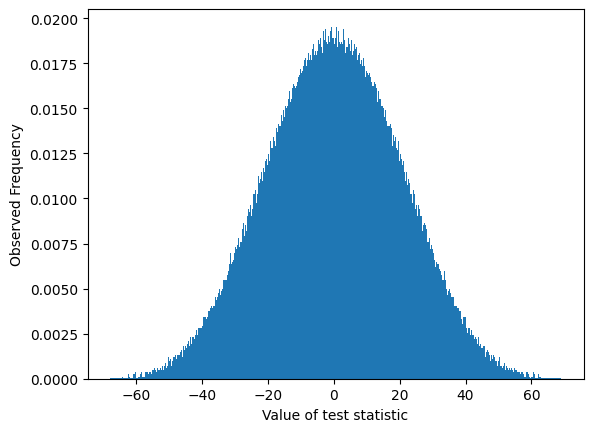

In [5]:
from itertools import product
import matplotlib.pyplot as plt

def statistic(d):
    # d is the differences in height between paired plants
    # the statistic is the sum of these differences
    return np.sum(d)

# compute the statistic for all possible combinations of signs on the elements of `d`
def null_distribution(d):
    signs = (-1, 1) 
    n = len(d)  # number of observations per sample
    null_distribution = []
    for dsigns in product(*[signs]*n):
        stat = statistic(d * dsigns)
        null_distribution.append(stat)
    return null_distribution

d = x - y
null_dist = null_distribution(d)
assert len(null_dist) == 2**15
bins = np.unique(null_dist).tolist()
bins.append(np.max(null_dist)+1)
plt.hist(null_dist, density=True, bins=bins)
plt.xlabel("Value of test statistic")
plt.ylabel("Observed Frequency")

> In just 863 cases out of 32,768 the total deviation will have a positive value as great as or greater than that observed.

The $p$-value is simply the ratio of the two.

In [6]:
assert np.sum(null_dist >= statistic(d)) == 863
pvalue = np.sum(null_dist >= statistic(d)) / len(null_dist)
print(f"t-test p-value: {res_t.pvalue}")
print(f"permutation test p-value: {pvalue}")

t-test p-value: 0.02485147201090045
permutation test p-value: 0.026336669921875


The two tests agree remarkably well in this case, suggesting the applicability of the t-test even when the original data are not strictly normally distributed.

`permutation_test` minimizes the code required to perform the same procedure. The most essential difference here compared to the independent 
sample tests above is that we pass `permutation_type='samples'` instead of `permutation_type='independent'`. Note also that we can simply pass `np.sum` as the statistic because it satisfies the required interface, even with `vectorized=True`.

In [7]:
# Note that the first argument of `permutation_test` is a sequence containing all the samples.
# We only have one sample here, but it still needs to be in a sequence.
res = stats.permutation_test((d,), np.sum, alternative='greater', permutation_type='samples', vectorized=True, n_resamples=np.inf)
assert res.pvalue == pvalue

The value of the `permutation_type`, "samples", comes from the fact that permuting the signs of the differences is equivalent to permuting the *sample* to which each paired observation is assigned. That is, we can obtain the same $p$-value by performing a two-sample test in which observations are exchanged between the two samples in all possible ways *without* breaking up pairs. This is what `permutation_test` does with `permutation_type='samples'` when there are two or more samples.

In [8]:
def statistic(x, y, axis=0):
    # observations will be permuted between samples `x` and `y`,
    # changing the sign of the corresponding element of `d` 
    d = x - y
    return np.sum(d, axis=axis)

res = stats.permutation_test((x, y), statistic, alternative='greater', permutation_type='samples', n_resamples=np.inf)
assert res.pvalue == pvalue

Other common hypothesis tests can be performed as paired-sample permutation tests. We continue with several comparisons against `scipy.stats.wilcoxon` to further illustrate the usage of `permutation_test` with `permutation_type='samples'`.

#### Two-sample Test

[`wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html) is to `ttest_rel` as `mannwhitneyu` is to `ttest_ind`; it is a nonparametric permutation test of the null hypothesis that each observation in a pair is drawn from the same distribution. Because it is a paired-sample test, it computes the $p$-value by reassigning observations between the samples in all possible ways while maintaining the pairs.

In [15]:
rng = np.random.default_rng()
x = rng.random(7)
y = rng.random(7)
# Each element in `x` is paired with the corresponding element of `y` 
stats.wilcoxon(x, y, alternative='greater')

WilcoxonResult(statistic=np.float64(11.0), pvalue=np.float64(0.7109375))

Using `wilcoxon` to compute only the statistic, we can use `permutation_test` to calculate precisely the same $p$-value.

In [16]:
def statistic(x, y):
    return stats.wilcoxon(x, y, alternative='greater', method='approx').statistic

res = stats.permutation_test((x, y), statistic, alternative='greater', permutation_type='samples')
res.pvalue

np.float64(0.7109375)

(The warning can be safely ignored because it is referring to the $p$-value returned by the test, whereas we are using only the statistic value.)

Again, the advantage of `permutation_test` is its ability to handles ties in the data; `wilcoxon` does not.

In [18]:
x = rng.integers(0, 5, size=7)
y = rng.integers(0, 5, size=7)
stats.wilcoxon(x, y, method='exact')

WilcoxonResult(statistic=np.float64(6.0), pvalue=np.float64(0.8125))

In [19]:
res = stats.permutation_test((x, y), statistic, permutation_type='samples')
res.statistic, res.pvalue

(np.float64(9.0), np.float64(1.0))

#### One-sample Test

The `wilcoxon` statistic does not depend on the specific values in `x` and `y`, only on the values of `x - y`. Instead of passing `x` and `y` into `wilcoxon` separately, `wilcoxon` can accept a single sample - the differences between paired observations.

In [20]:
x = np.array([209, 200, 177, 169, 159, 169, 187])
y = np.array([151, 168, 147, 164, 166, 163, 176])
stats.wilcoxon(x - y, alternative='greater', method='exact')

WilcoxonResult(statistic=np.float64(25.0), pvalue=np.float64(0.0390625))

As described above, this is relatively common in paired-sample tests (e.g. see also `ttest_rel`), so `permutation_test` also supports single samples as input and forms the null distribution by permuting the *signs* of each observation.

In [21]:
def statistic(d):
    # return just the Mann-Whitney U statistic
    return stats.wilcoxon(d, alternative='greater').statistic

res = stats.permutation_test((x-y,), statistic, alternative='greater', permutation_type='samples')
res.pvalue

np.float64(0.0390625)

#### Gotchas

Suppose that we wish to perform the Wilcoxon test with a two-sided alternative. We might expect that `alternative='two-sided'` should be specified everywhere the `alternative` parameter is accepted.

In [22]:
alternative = 'two-sided'
res1 = stats.wilcoxon(x - y, alternative=alternative)

def statistic(d):
    return stats.wilcoxon(d, alternative=alternative).statistic

res2 = stats.permutation_test((x-y,), statistic, alternative=alternative, permutation_type='samples')

print(res1.pvalue, res2.pvalue)

0.078125 0.15625


This guess was not correct; the `pvalue` returned by `permutation_test` is greater by a factor of two. Note that the documentation of `wilcoxon` states:
> If `alternative` is “two-sided”, [the `statistic` is] the sum of the ranks of the differences above or below zero, whichever is smaller.

The sign information that should be carried by the statistic ("above or below zero") is not preserved by `statistic`. This can be corrected by passing `alternative='greater'` or `alternative='less'` in the call to `wilcoxon` so that that the statistic is always:
> the sum of the ranks of the differences above zero.

In [23]:
def statistic(d):
    # `alternative='less'` or `alternative='greater'` will work
    return stats.wilcoxon(d, alternative='less').statistic

res2 = stats.permutation_test((x-y,), statistic, alternative=alternative, permutation_type='samples')

np.testing.assert_allclose(res2.pvalue, res1.pvalue, atol=1e-15)

### Other Tests
`permutation_test` with `permutation_type='samples'` is a versatile tool for comparing paired samples. Provided only data and a statistic, it can produce the null distribution and replicate the $p$-value of similar tests in SciPy, and it may be more accurate than these existing implementations, especially for small samples and when there are ties:

- [`ttest_rel`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html)
- [`wilcoxon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html)
- [`page_trend_test`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.page_trend_test.html)

In addition, `permutation_test` with `permutation_type='samples'` can be used to perform tests not yet implemented in SciPy.

However, there are yet other types of permutation tests that assume neither that samples are independent nor paired. We conclude the study of `permutation_test` with [Correlated-Sample Tests](https://nbviewer.org/github/scipy/scipy-cookbook/blob/main/ipython/ResamplingAndMonteCarloMethods/resampling_tutorial_2c.ipynb).